In [1]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, KFold
import matplotlib.pyplot as plt
import math
from scipy.stats import boxcox
import seaborn as sns
import gmplot
from sklearn.metrics import classification_report, confusion_matrix, r2_score, accuracy_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score
from sklearn import metrics
import numpy as np

In [2]:
#read in the target data
#link: https://www.kaggle.com/jboysen/google-project-sunroof
solar_data = pd.read_csv('Solar Data/project-sunroof-postal_code-09082017.csv')
solar_data.drop(0, inplace = True)
#convert the column containing postal codes from str to int
solar_data['region_name'] = solar_data['region_name'].apply(lambda x : int(x))

In [3]:
#read in the median home value data
#link: http://files.zillowstatic.com/research/public/Zip/Zip_Zhvi_Summary_AllHomes.csv
homevalue = pd.read_csv('Solar Data/Zip_Zhvi_Summary_AllHomes.csv')
homevalue = homevalue[['RegionName', 'Zhvi']]

In [4]:
#read in census data
#scraped from Census.gov see scrape census.gov.py file
census = pd.read_csv('scraped_from_census.csv')
census = census[['zipcode', 'population','medianage', 'medianincome','pctownocc']]
#merge target data with census data
census_solar = solar_data[['region_name','existing_installs_count']].merge(census, left_on = 'region_name', right_on = 'zipcode', how = 'inner')
#merge in home value data with other data
census_solar_home = census_solar.merge(homevalue, left_on = 'zipcode', right_on = 'RegionName', how = 'inner')
#read in solar radiation data
#scraped from nrel see Scrape_Nrel_Solar.py
solar_rad = pd.read_csv('Solar_Radiation_by_zip.csv')
#drop the rows where the solar data was not available
solar_rad = solar_rad[solar_rad.solar_radiation !=  'error']
#merge solar radiation data in to the rest of the data
census_solar_home_rad = census_solar_home.merge(solar_rad,on = 'zipcode', how = 'inner')

In [5]:
#trim the unneeded columns from the data
census_solar_home_rad= census_solar_home_rad[['zipcode',  'population',
       'medianage', 'medianincome', 'pctownocc', 'Zhvi',
       'solar_radiation','existing_installs_count']]
#convert solarion radiation data from str to float
census_solar_home_rad['solar_radiation'] = census_solar_home_rad['solar_radiation'] .apply(lambda x : float(x))
#rename all the combined data as data
data = census_solar_home_rad

First we need to establish a target feature.  We'll call that per_capita and calculate it as number of installs for every 100 people in a given geographic area (zip code)

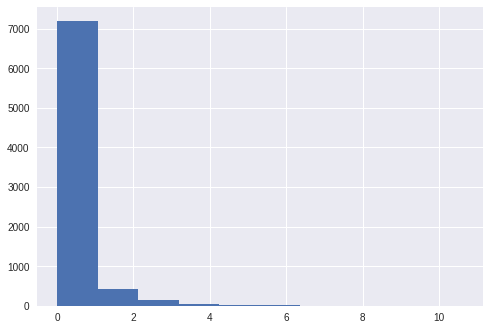

In [6]:
#generate a target feature.  Our target is the number of installs per 100 people
data['per_capita'] = (data['existing_installs_count']/data['population']*100)
#plot the target variable to get a sense as to what we are working with
plt.hist(data['per_capita'])
plt.show()

This initial data is heavily skewed towards zero.  So let's take a look at how we might be able to transform this data to make it easier for a model to get some footing.

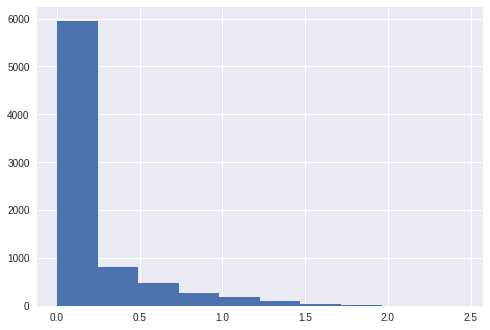

In [7]:
#try a log transformation on the variable to see if we can spread it out a little better
test = data['per_capita'].apply(lambda x: math.log(x+1))
plt.hist(test)
plt.show()

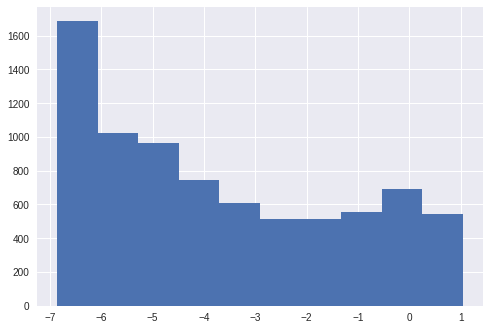

In [8]:
#try a boxcox transformation on the target to see if we can normalize it a bit
test = boxcox(data.per_capita.apply(lambda x: x+0.1))[0]
plt.hist(test)
plt.show()

In [9]:
#the boxcox transformation was good so overwrite the feature as the transformed boxcox data
data.per_capita = test

A box cox transformation on the target normalized the distribution quite well.  Lets see what we can do to the other variables. Zhvi (median home value) should be a strong feature.  Let's take a look at the distribution and see how me might play with that data. 

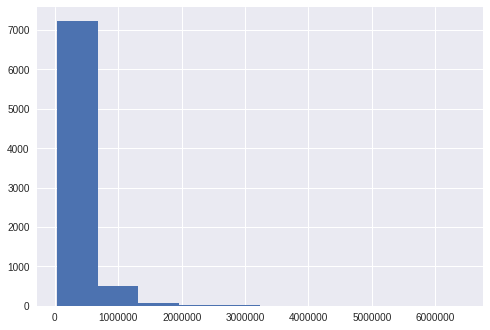

In [10]:
#plot home median home value data.  We have a similar issue here as we did with the target feature
plt.hist(data.Zhvi)
plt.show()

Well, there are some pretty extreme datapoints that I think we will want to eliminate so let's do that and then try some transformations

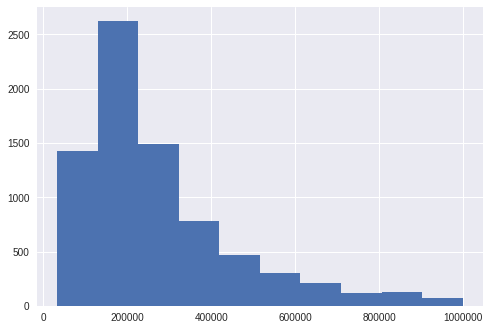

In [11]:
#lets drop the very overpriced homes, looks much better now, distribution has some spread to it.
data = data[data.Zhvi <= 1000000]
plt.hist(data.Zhvi)
plt.show()

Thats some pretty fair ditribution on Zhvi and we got the correlation between our target and the feature up to 0.48.  Let's see if we can do that with some other features.  Let's look at sunlight next.

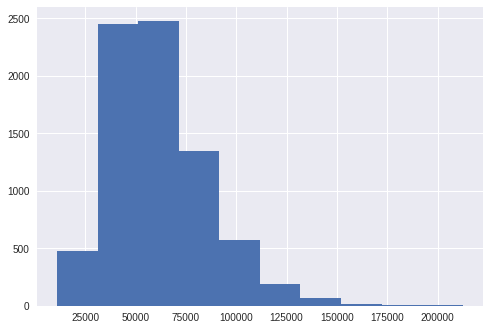

In [12]:
#median income also seems to have some outliers
plt.hist(data['medianincome'])
plt.show()

In [13]:
#drop those outliers for median income
data = data[data['medianincome'] < 150000]

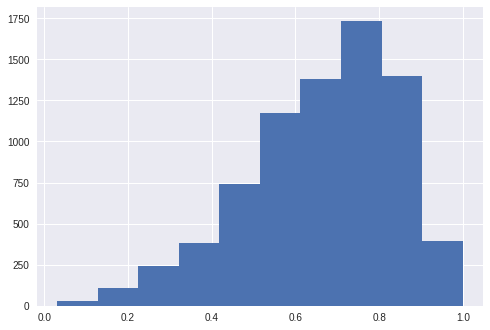

In [14]:
#the percent of homes occupied by the owner looks like a healthy distribution, we can leave it alone.
plt.hist(data['pctownocc'])
plt.show()

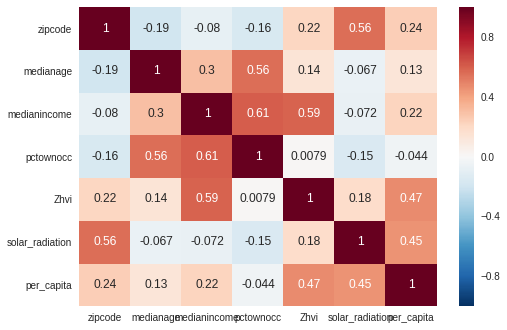

In [15]:
#plot a correlation map just to see how data are related
corr = data.drop(['existing_installs_count','population'], axis = 1).corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot= True)
plt.show()

In [16]:
#drop Nan for good measure
data.dropna(inplace = True)
#set features to X
X = data.drop(['existing_installs_count','population','per_capita', 'zipcode'], axis = 1)
#and target to Y
Y = data['per_capita']

In [17]:
#set lower 1/3 bound value for setting up the target as a classification problem with 3 classes
low3 = data.per_capita.median() - data.per_capita.std()/2
#set higher 1/3 bound value for setting up the target as a classification problem with 3 classes
high3 = data.per_capita.median() + data.per_capita.std()/2
#set median for use of classification with only 2 classes
median = data.per_capita.median()

# Evaluating as a 2 class problem

# Random Forest

In [18]:
#define classes for classification model 0 for bad, 1 fgood market.
data['class'] = data['per_capita'].apply(lambda x: 0 if x <= median else 1)

In [19]:
#define features for classifcation model
X = data.drop(['existing_installs_count','population','per_capita', 'zipcode', 'class'], axis = 1)
#define target for classification model
Y = data['class']

In [20]:
rfc = RandomForestClassifier(n_estimators=100)
score = cross_val_score(rfc, X, Y, cv=5)
print(score.mean())
print(score.std())
score

0.652645606157
0.0401578291554


array([ 0.58707124,  0.66226913,  0.63390501,  0.70627063,  0.67371202])

In [21]:
#train test split
X_train, X_test,Y_train, Y_test = train_test_split(X, Y, train_size = 0.8)

In [22]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, Y_train)
Y_rand = rfc.predict(X_test)
print('Accuracy: {}'.format(rfc.score(X_test, Y_test)))

Accuracy: 0.758575197889182


In [23]:
confusion_matrix(Y_test,Y_rand)

array([[598, 155],
       [211, 552]])

In [24]:
print(classification_report(Y_test,Y_rand))

             precision    recall  f1-score   support

          0       0.74      0.79      0.77       753
          1       0.78      0.72      0.75       763

avg / total       0.76      0.76      0.76      1516



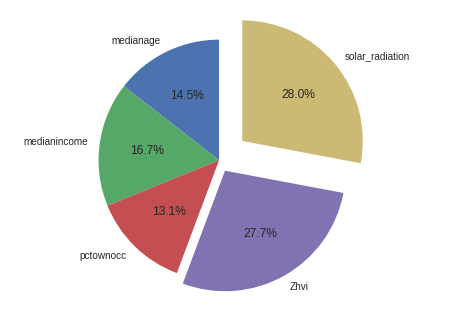

In [25]:
#set lables from features
labels = X_train.columns
#retrieve relative importance of features from random forests
sizes = rfc.feature_importances_
#set explode parameters to make the chart look nice
explode = (0, 0,0  ,.1, .25)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')

plt.show()

In [26]:
class binensemble():
    
    def __init__ (self):
        self.erfc = RandomForestClassifier(n_estimators=100)
        self.egbc = GradientBoostingClassifier()
        self.elr = LogisticRegression()
        
        
    def fit (self, data, target):
        self.erfc.fit(data, target)
        self.egbc.fit(data, target)
        self.elr.fit(data, target)
    def predict(self,to_pred):
        
        Y_rand = self.erfc.predict(to_pred)
        Y_grad = self.egbc.predict(to_pred)
        Y_lr = self.elr.predict(to_pred)
        ensembleModel = pd.DataFrame()
        ensembleModel['random'] = Y_rand
        ensembleModel['gradient'] = Y_grad
        ensembleModel['logis'] = Y_lr

        ensembleresults = ensembleModel.mode(axis = 1)

        return ensembleresults

In [27]:
ensemble = binensemble()

ensemble.fit(X_train, Y_train)
Y_ = ensemble.predict(X_test)
accuracy_score(Y_test, Y_)

0.76715039577836408

In [28]:
print(classification_report(Y_test,Y_))

             precision    recall  f1-score   support

          0       0.74      0.81      0.78       753
          1       0.79      0.73      0.76       763

avg / total       0.77      0.77      0.77      1516



In [29]:
cmat = confusion_matrix(Y_test,Y_rand)
cmat

array([[598, 155],
       [211, 552]])

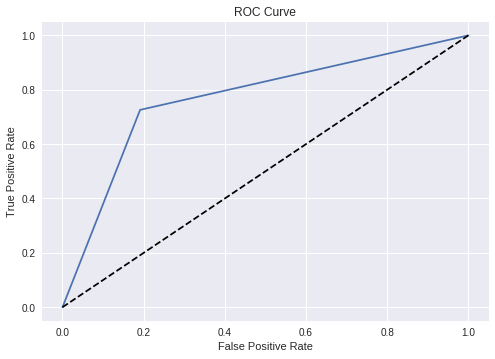

AUC: 0.767423099215


In [30]:
fpr, tpr, _ = roc_curve(Y_test, Y_)
# Print ROC curve
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1], '--', color = 'black')
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

# Mapping 2 class problem

In [31]:
#reread in my raw data to make predictions on other data
homevalue = pd.read_csv('Solar Data/Zip_Zhvi_Summary_AllHomes.csv')
homevalue = homevalue[['RegionName', 'Zhvi']]
census = pd.read_csv('scraped_from_census.csv')
census= census[['zipcode', 'population','medianage', 'medianincome','pctownocc']]
census_solar_home = census.merge(homevalue, left_on = 'zipcode', right_on = 'RegionName', how = 'inner')
solar_rad = pd.read_csv('Solar_Radiation_by_zip.csv')
solar_rad = solar_rad[solar_rad.solar_radiation !=  'error']
data_to_predict = census_solar_home.merge(solar_rad,on = 'zipcode', how = 'inner')

In [32]:
#drop zip codes that were used in the model generation
data_to_predict = data_to_predict[~data_to_predict.zipcode.isin(data.zipcode)]
X_ = data_to_predict.drop(['population','RegionName', 'zipcode'], axis = 1)

In [33]:
#drop zip codes that were used in the model generation
data_to_predict = data_to_predict[~data_to_predict.zipcode.isin(data.zipcode)]
X_ = data_to_predict.drop(['population','RegionName', 'zipcode'], axis = 1)

In [34]:
data_to_predict.reset_index(inplace = True)

In [35]:
#save the predicted values
data_to_predict['class'] = ensemble.predict(X_)

In [36]:
#load all latitude and longitudes for zip codes
zip_lats_longs = pd.read_csv('us_postal_codes.csv')
#drop the unnessesary parts of the data
zip_lats_longs = zip_lats_longs[['Zip Code', 'Latitude','Longitude']]
#merge the lats and longs onto the data with the predicted values
to_plot = data_to_predict.merge(zip_lats_longs, left_on = 'zipcode', right_on = 'Zip Code', how = 'inner')

In [37]:
#break up the data into 2 datasets, good, medium and bad predicted markets
good_markets = to_plot[to_plot['class'] == 1]
bad_markets = to_plot[to_plot['class'] == 0]
#center and zoom the map over the united states
gmap = gmplot.GoogleMapPlotter(to_plot['Latitude'].mean(), to_plot['Longitude'].mean(), 4)
#plot green dots to represent good markets
gmap.scatter(good_markets['Latitude'], good_markets['Longitude'], '#228B22', size=4000, marker=False)
#plot red dots to represent bad markets
gmap.scatter(bad_markets['Latitude'], bad_markets['Longitude'], '#ff0000', size=4000, marker=False)
#draw the mapfile
gmap.draw('2classmarketprediction.html')

# Evaluating as a 3 class problem

In [38]:
#define classes for classification model 0 for bad, 1 for medium and 2 for good market.
data['class'] = data['per_capita'].apply(lambda x: 0 if x <= low3 else (2 if x >= high3 else 1))

In [39]:
#define features for classifcation model
X = data.drop(['existing_installs_count','population','per_capita', 'zipcode', 'class'], axis = 1)
#define target for classification model
Y = data['class']

In [40]:
rfc = RandomForestClassifier(n_estimators=100)
score = cross_val_score(rfc, X, Y, cv=5)
print(score.mean())
print(score.std())
score

0.478568729222
0.0486047861085


array([ 0.38826632,  0.51253298,  0.52242744,  0.5006605 ,  0.46895641])

In [41]:
#train test split
X_train, X_test,Y_train, Y_test = train_test_split(X, Y, train_size = 0.8)

In [42]:
rfc.fit(X_train, Y_train)
Y_ = rfc.predict(X_test)
print('Accuracy: {}'.format(rfc.score(X_test, Y_test)))

Accuracy: 0.5903693931398417


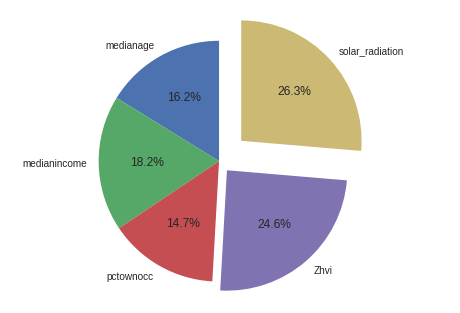

In [43]:
#set lables from features
labels = X_train.columns
#retrieve relative importance of features from random forests
sizes = rfc.feature_importances_
#set explode parameters to make the chart look nice
explode = (0, 0,0  ,.1, .25)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')

plt.show()

In [44]:
confusion_matrix(Y_test,Y_)

array([[271, 149,  51],
       [186, 220, 106],
       [ 43,  86, 404]])

In [45]:
print(classification_report(Y_test,Y_))

             precision    recall  f1-score   support

          0       0.54      0.58      0.56       471
          1       0.48      0.43      0.46       512
          2       0.72      0.76      0.74       533

avg / total       0.58      0.59      0.59      1516



In [46]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, Y_train)
Y_ = gbc.predict(X_test)
print('Accuracy: {}'.format(gbc.score(X_test, Y_test)))

Accuracy: 0.5857519788918206


In [47]:
confusion_matrix(Y_test,Y_)

array([[274, 136,  61],
       [180, 215, 117],
       [ 47,  87, 399]])

In [48]:
print(classification_report(Y_test,Y_))

             precision    recall  f1-score   support

          0       0.55      0.58      0.56       471
          1       0.49      0.42      0.45       512
          2       0.69      0.75      0.72       533

avg / total       0.58      0.59      0.58      1516



In [49]:
confusion_matrix(Y_test,Y_)

array([[274, 136,  61],
       [180, 215, 117],
       [ 47,  87, 399]])

In [50]:
print(classification_report(Y_test,Y_))

             precision    recall  f1-score   support

          0       0.55      0.58      0.56       471
          1       0.49      0.42      0.45       512
          2       0.69      0.75      0.72       533

avg / total       0.58      0.59      0.58      1516



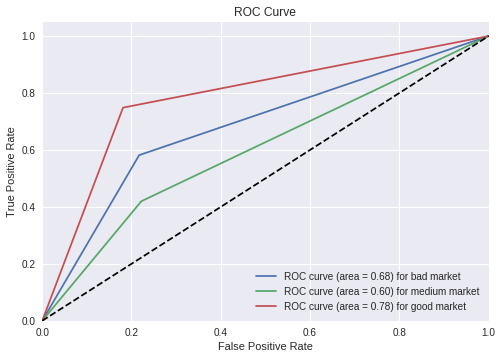

In [51]:
fpr = dict()
tpr = dict()
roc_auc = dict()

dic = {0:"bad market",
       1:"medium market",
       2:"good market"
      }

#generate tpr and fpr for each class
for i in range(0,3):
    fpr[i], tpr[i], _ = roc_curve(pd.get_dummies(Y_test)[i], pd.get_dummies(Y_)[i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Plot of a ROC curve
plt.figure()
for i in range(0,3):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for {}'.format(dic[i]) % roc_auc[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Mapping the 3 class problem

In [52]:
#reread in my raw data to make predictions on other data
homevalue = pd.read_csv('Solar Data/Zip_Zhvi_Summary_AllHomes.csv')
homevalue = homevalue[['RegionName', 'Zhvi']]
census = pd.read_csv('scraped_from_census.csv')
census= census[['zipcode', 'population','medianage', 'medianincome','pctownocc']]
census_solar_home = census.merge(homevalue, left_on = 'zipcode', right_on = 'RegionName', how = 'inner')
solar_rad = pd.read_csv('Solar_Radiation_by_zip.csv')
solar_rad = solar_rad[solar_rad.solar_radiation !=  'error']
data_to_predict = census_solar_home.merge(solar_rad,on = 'zipcode', how = 'inner')

In [53]:
#drop zip codes that were used in the model generation
data_to_throw = data_to_predict[data_to_predict.zipcode.isin(data.zipcode)]
data_to_predict = data_to_predict[~data_to_predict.zipcode.isin(data.zipcode)]
X_2 = data_to_throw.drop(['population','RegionName', 'zipcode'], axis = 1)
X_ = data_to_predict.drop(['population','RegionName', 'zipcode'], axis = 1)

In [54]:
#save the predicted values
data_to_predict['class'] = gbc.predict(X_)
data_to_throw['class'] = gbc.predict(X_2)

In [55]:
#load all latitude and longitudes for zip codes
zip_lats_longs = pd.read_csv('us_postal_codes.csv')
#drop the unnessesary parts of the data
zip_lats_longs = zip_lats_longs[['Zip Code', 'Latitude','Longitude','State.1']]
#merge the lats and longs onto the data with the predicted values
to_plot = data_to_predict.merge(zip_lats_longs, left_on = 'zipcode', right_on = 'Zip Code', how = 'inner')
to_plot2 = data_to_throw.merge(zip_lats_longs, left_on = 'zipcode', right_on = 'Zip Code', how = 'inner')

In [56]:
#break up the data into 3 datasets, good, medium and bad predicted markets
good_markets = to_plot[to_plot['class'] == 2]
medium_markets = to_plot[to_plot['class'] == 1]
bad_markets = to_plot[to_plot['class'] == 0]
#center and zoom the map over the united states
gmap = gmplot.GoogleMapPlotter(to_plot['Latitude'].mean(), to_plot['Longitude'].mean(), 4)
#plot green dots to represent good markets
gmap.scatter(good_markets['Latitude'], good_markets['Longitude'], '#228B22', size=4000, marker=False)
#plot yellow dots to represent medium markets
gmap.scatter(medium_markets['Latitude'], medium_markets['Longitude'], '#ffff00', size=4000, marker=False)
#plot red dots to represent bad markets
gmap.scatter(bad_markets['Latitude'], bad_markets['Longitude'], '#ff0000', size=4000, marker=False)
#draw the mapfile
gmap.draw('3classmarketprediction.html')

# Replot while including the training data
Due to the nature of the problem for this model I have included the training data in the final plot as that data is also interesting in the context of identifying business opportunities in the solar market as a whole.

In [57]:
to_plot2 = pd.concat([to_plot, to_plot2], join = 'inner')
#break up the data into 3 datasets, good, medium and bad predicted markets
good_markets = to_plot2[to_plot2['class'] == 2]
medium_markets = to_plot2[to_plot2['class'] == 1]
bad_markets = to_plot2[to_plot2['class'] == 0]
#center and zoom the map over the united states
gmap = gmplot.GoogleMapPlotter(to_plot['Latitude'].mean(), to_plot['Longitude'].mean(), 4)
#plot green dots to represent good markets
gmap.scatter(good_markets['Latitude'], good_markets['Longitude'], '#228B22', size=4000, marker=False)
#plot yellow dots to represent medium markets
gmap.scatter(medium_markets['Latitude'], medium_markets['Longitude'], '#ffff00', size=4000, marker=False)
#plot red dots to represent bad markets
gmap.scatter(bad_markets['Latitude'], bad_markets['Longitude'], '#ff0000', size=4000, marker=False)
#draw the mapfile
gmap.draw('3classmarketpredictionalltrain.html')

# Analysis of Results

In [58]:
def compare(data1, data2, feature):
    plt.hist(data1[feature], label = data1.name, normed = True, color = 'blue')
    plt.axvline(data1[feature].mean(), linestyle='solid', linewidth=2, color = 'blue')
    plt.hist(data2[feature], label = data2.name, alpha = 0.5, normed = True, color = 'green')
    plt.axvline(data2[feature].mean(), linestyle='solid', linewidth=2, color = 'green')
    plt.title('Comparing {} between datasets'.format(feature))
    plt.legend()
    plt.show()

In [59]:
def comparethree(data1, data2,data3, feature):
    plt.hist(data1[feature], label = data1.name, normed = True, color = 'red')
    plt.axvline(data1[feature].mean(), linestyle='solid', linewidth=2, color = 'red')
    plt.hist(data2[feature], label = data2.name, alpha = 0.5, normed = True, color = 'blue')
    plt.axvline(data2[feature].mean(), linestyle='solid', linewidth=2, color = 'blue')
    plt.hist(data3[feature], label = data3.name, alpha = 0.5, normed = True, color = 'green')
    plt.axvline(data3[feature].mean(), linestyle='solid', linewidth=2, color = 'green')
    plt.title('Comparing {} between datasets'.format(feature))
    plt.legend()
    plt.show()

In [60]:
to_plot.solar_radiation = to_plot.solar_radiation.apply(lambda x: float(x))
to_plot['income_home_value_ratio'] = to_plot.medianincome/to_plot.Zhvi

In [61]:

highsunstates = ['CA', 'NV', 'UT', 'CO','AZ','NM', 'HI', 'FL']
HighSun = to_plot[to_plot['State.1'].isin(highsunstates)]
HighSun.name = 'HighSun'

Not_HighSun = to_plot[~to_plot['State.1'].isin(highsunstates)]
Not_HighSun.name = 'Not_HighSun'

The western United States has a clearly higher rate of good markets for solar than the rest of the country as visualized in the histogram below.  But why is that?  Let's also take a look at the breakdown of the features from these two regions and see if there are any significant pattern differences. We've included Floridia in the Western US because it is so far south that it is also a place that recieves a lot more sun.

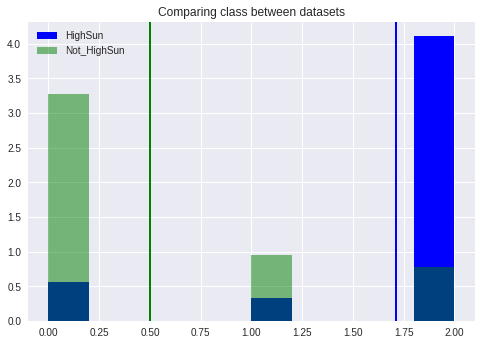

In [62]:
compare(HighSun, Not_HighSun, 'class')

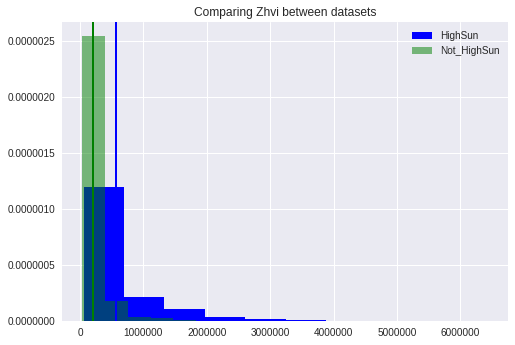

In [63]:
compare(HighSun, Not_HighSun, 'Zhvi')

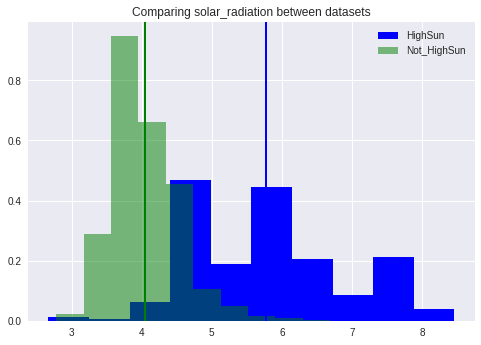

In [64]:
compare(HighSun, Not_HighSun, 'solar_radiation')

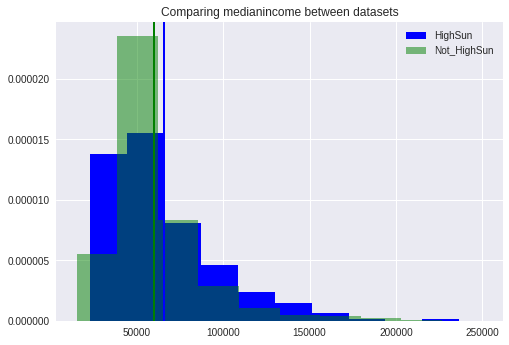

In [65]:
compare(HighSun, Not_HighSun, 'medianincome')

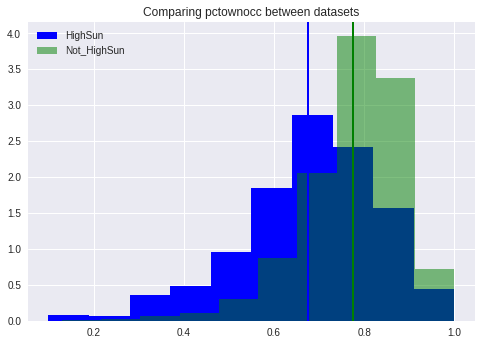

In [66]:
compare(HighSun, Not_HighSun, 'pctownocc')

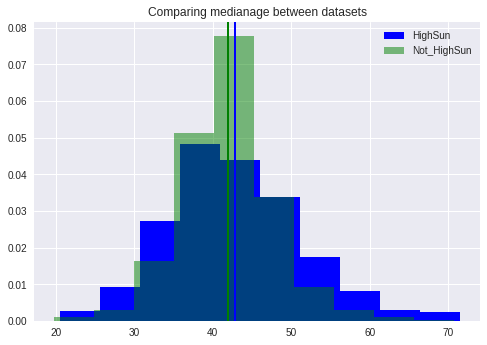

In [67]:
compare(HighSun, Not_HighSun, 'medianage')

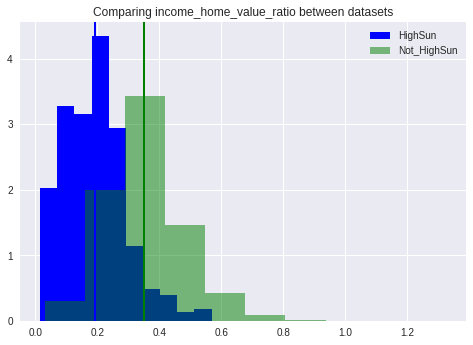

In [68]:
compare(HighSun, Not_HighSun, 'income_home_value_ratio')

It seems like the main difference between the western United States compared to the rest of the country is the amount of sun that that area of the country gets, however surprisingly it seems fewer people own their homes in the sunny states and also the sunnier places have higher incomes and lower income to home value ratios.  This is even more interesting as home values seem similarly distributed between sunny and non-sunny places.  But there are still areas in the rest of the country that show regions where solar is an attractive market.  So why is that.

In [69]:
Not_HighSunclass0 = Not_HighSun[Not_HighSun['class'] == 0]
Not_HighSunclass0.name = 'Bad Markets'
Not_HighSunclass1 = Not_HighSun[Not_HighSun['class'] == 1]
Not_HighSunclass1.name = 'Medium Markets'
Not_HighSunclass2 = Not_HighSun[Not_HighSun['class'] == 2]
Not_HighSunclass2.name = 'Good Markets'

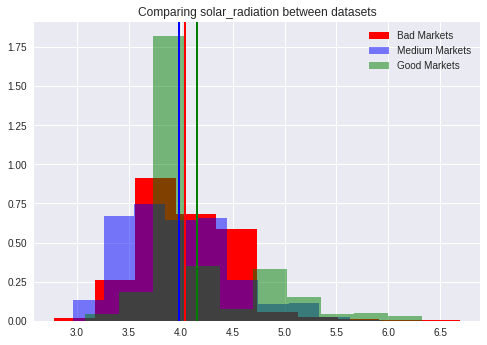

In [70]:
comparethree(Not_HighSunclass0, Not_HighSunclass1,Not_HighSunclass2, 'solar_radiation')

In the non western portion of the country the amount of sun that hits the different zipcodes seem to have little bearing on the results as all three classes have similar distributions of sunlight.  So we need to dive into other factors in these regions of the country to get some predictive knowledge.

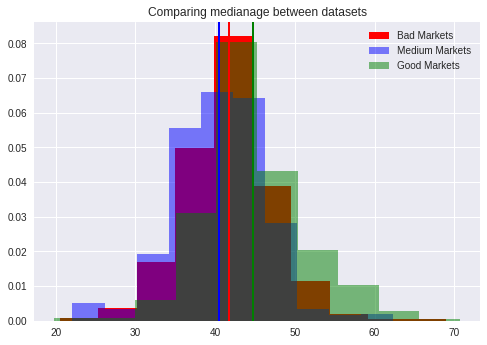

In [71]:
comparethree(Not_HighSunclass0, Not_HighSunclass1,Not_HighSunclass2, 'medianage')

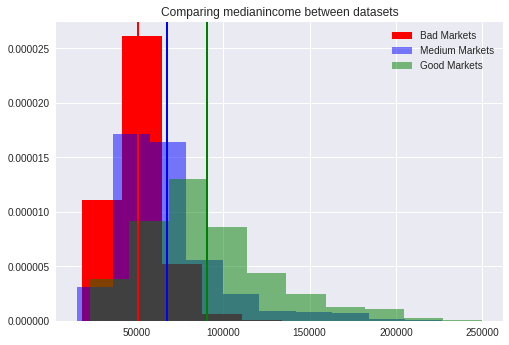

In [72]:
comparethree(Not_HighSunclass0, Not_HighSunclass1,Not_HighSunclass2, 'medianincome')

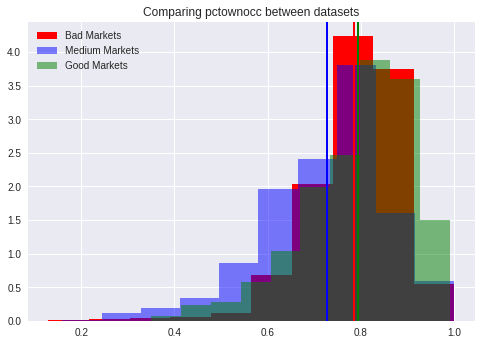

In [73]:
comparethree(Not_HighSunclass0, Not_HighSunclass1,Not_HighSunclass2, 'pctownocc')

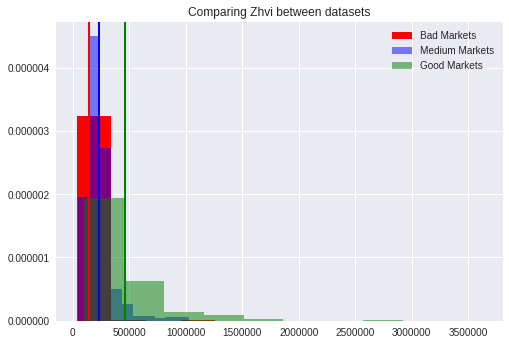

In [74]:
comparethree(Not_HighSunclass0, Not_HighSunclass1,Not_HighSunclass2, 'Zhvi')

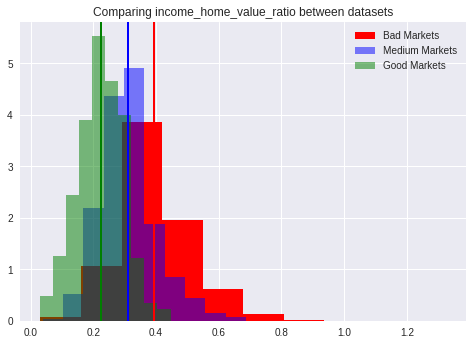

In [75]:
comparethree(Not_HighSunclass0, Not_HighSunclass1,Not_HighSunclass2, 'income_home_value_ratio')

No one value seems to jump out as strong distributional differences between a good and bad market, including the ratio of home value to income.

# Use Case Examples

In [76]:
to_plot['income_home_value_ratio'] = to_plot.medianincome/to_plot.Zhvi

Grand Island, NE:

Interestingly here in the Grand Island Nebraska area we have two zip codes that show similar incomes and home values but are classified differently.  The item to note here is the percent of homes lived in by owners between the two datapoints.

In [77]:
to_plot[to_plot['zipcode'].isin(['68803','68801'])]

,zipcode,population,medianage,medianincome,pctownocc,RegionName,Zhvi,solar_radiation,class,Zip Code,Latitude,Longitude,State.1,income_home_value_ratio
4091,68801,30551.0,32.9,45806.0,0.58,68801,131500,4.97,1,68801,40.9219,-98.3411,NE,0.348335
4092,68803,22838.0,40.3,51715.0,0.71,68803,165500,4.92,2,68803,40.9286,-98.3873,NE,0.312477


North Chicago, IL:

In North Chicago we get 4 samples all with high ownership rates but 3 different classes.  Here the high home value and high income outweight other factors.  Also interesting here is the very low income to home value ratio, which we saw before in the histograms that it can be an indicator as well.

In [78]:
to_plot[to_plot['zipcode'].isin(['60051','60068', '60081','60093'])]

,zipcode,population,medianage,medianincome,pctownocc,RegionName,Zhvi,solar_radiation,class,Zip Code,Latitude,Longitude,State.1,income_home_value_ratio
3807,60051,24769.0,39.0,74715.0,0.81,60051,172000,3.75,0,60051,42.3542,-88.2294,IL,0.434390
3812,60068,37125.0,44.8,90484.0,0.85,60068,388900,3.58,1,60068,42.0122,-87.8417,IL,0.232666
3815,60081,9874.0,42.2,84799.0,0.85,60081,251900,3.77,1,60081,42.4413,-88.2237,IL,0.336638
3818,60093,19384.0,43.5,156047.0,0.92,60093,917000,3.78,2,60093,42.1054,-87.7535,IL,0.170171


Pontiac, MI:

In the Pontiac area of Michigan we see high ownership, high income and high home value adding up to good markets. Also we see again that the income to home value ratio is very low.

In [79]:
to_plot[to_plot['zipcode'].isin(['48302','48304', '48341','48342','48326'])]

,zipcode,population,medianage,medianincome,pctownocc,RegionName,Zhvi,solar_radiation,class,Zip Code,Latitude,Longitude,State.1,income_home_value_ratio
3326,48302,15475.0,49.1,127068.0,0.89,48302,478400,3.64,2,48302,42.5848,-83.2821,MI,0.265610
3327,48304,16077.0,50.3,105830.0,0.85,48304,373500,3.64,2,48304,42.5870,-83.2359,MI,0.283347
3331,48326,20966.0,33.5,52976.0,0.51,48326,156300,3.56,1,48326,42.6583,-83.2375,MI,0.338938
3336,48341,16074.0,38.2,34139.0,0.50,48341,80200,3.56,1,48341,42.6294,-83.3041,MI,0.425673
3337,48342,16575.0,31.7,20606.0,0.42,48342,65900,3.56,0,48342,42.6439,-83.2792,MI,0.312686


San Francisco, CA:

One of the most intestesting sections of data is San Francisco.  All the properties are million dollar or more properties.  And income is high nearly across the board as well.  However, there are areas with very low home ownership rates and those are indicating very bad market conditions.

In [80]:
sfzips = ['94102', '94103', '94104', '94105', '94107', '94108', '94109', '94110', '94111', '94112', '94114',
          '94115', '94116', '94117', '94118', '94121', '94122', '94123', '94124', '94127', '94129', '94130',
          '94131', '94132', '94133', '94134', '94158']
to_plot[to_plot['zipcode'].isin(sfzips)]

,zipcode,population,medianage,medianincome,pctownocc,RegionName,Zhvi,solar_radiation,class,Zip Code,Latitude,Longitude,State.1,income_home_value_ratio
4946,94105,6108.0,36.8,172570.0,0.47,94105,1085600,4.78,2,94105,37.7864,-122.3892,CA,0.158963
4947,94107,27505.0,37.0,121167.0,0.42,94107,1165700,4.78,2,94107,37.7621,-122.3971,CA,0.103944
4948,94108,13995.0,43.5,40435.0,0.10,94108,1003000,4.05,0,94108,37.7929,-122.4079,CA,0.040314
4949,94109,54817.0,36.5,66276.0,0.16,94109,1147000,4.05,0,94109,37.7917,-122.4186,CA,0.057782
4950,94110,70949.0,36.4,90364.0,0.36,94110,1379800,4.05,0,94110,37.7509,-122.4153,CA,0.065491
4951,94111,3527.0,46.3,91603.0,0.28,94111,1136000,4.05,0,94111,37.7974,-122.4001,CA,0.080636
4952,94114,32423.0,41.5,125265.0,0.49,94114,1692000,4.05,2,94114,37.7587,-122.4330,CA,0.074034
4953,94115,34236.0,37.7,89811.0,0.29,94115,1412400,4.05,0,94115,37.7856,-122.4358,CA,0.063588
4954,94116,45156.0,43.6,87321.0,0.67,94116,1250400,4.05,2,94116,37.7441,-122.4863,CA,0.069834
4955,94117,39052.0,34.3,108429.0,0.30,94117,1488300,4.05,0,94117,37.7712,-122.4413,CA,0.072854


Washington, DC:

In DC we see much the same pattern as in SF.  High income high home values but in low ownership rate zip codes we see non-ideal markets.

In [81]:
washingtondczips = ['22101', '22201', '22202', '22203', '22204', '22205', '22206', '22207', '22209', 
                    '22211', '22213', '22214', '20001', '20004', '20005', '20036', '20009', '20007',
                    '20010', '2008', '20016']
to_plot[to_plot['zipcode'].isin(washingtondczips)]

,zipcode,population,medianage,medianincome,pctownocc,RegionName,Zhvi,solar_radiation,class,Zip Code,Latitude,Longitude,State.1,income_home_value_ratio
1401,20004,1667.0,41.0,135859.0,0.52,20004,464300,4.19,1,20004,38.8930,-77.0263,DC,0.292610
1658,22101,29811.0,45.7,179743.0,0.84,22101,972000,4.27,1,22101,38.9326,-77.1706,VA,0.184921
1672,22203,23390.0,31.5,95775.0,0.34,22203,539200,4.26,0,22203,38.8738,-77.1142,VA,0.177624
1673,22204,52834.0,34.1,79078.0,0.40,22204,492200,4.19,2,22204,38.8590,-77.0997,VA,0.160662
1674,22205,19278.0,38.5,162083.0,0.75,22205,800000,4.26,1,22205,38.8836,-77.1395,VA,0.202604
1675,22206,21126.0,34.7,102365.0,0.47,22206,432400,4.19,1,22206,38.8415,-77.0905,VA,0.236737
1676,22207,32241.0,40.3,167816.0,0.83,22207,906900,4.27,1,22207,38.9033,-77.1263,VA,0.185044
1677,22213,3530.0,38.3,159352.0,0.75,22213,750500,4.26,1,22213,38.8954,-77.1633,VA,0.212328
